In [11]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import glob
import os
import uns
import pandas as pd
folder = '/home/chrisv/code/train_output'
#folder = '/Users/chrisv/Dropbox/CDIPS/fcn_train_log/BatchOf10'

filepattern = '*_prediction.npy*'
files = glob.glob(os.path.join(folder, filepattern))
files[:10]

['/home/chrisv/code/train_output/14_92_prediction.npy',
 '/home/chrisv/code/train_output/21_109_prediction.npy',
 '/home/chrisv/code/train_output/11_24_prediction.npy',
 '/home/chrisv/code/train_output/47_13_prediction.npy',
 '/home/chrisv/code/train_output/13_45_prediction.npy',
 '/home/chrisv/code/train_output/35_57_prediction.npy',
 '/home/chrisv/code/train_output/44_108_prediction.npy',
 '/home/chrisv/code/train_output/14_32_prediction.npy',
 '/home/chrisv/code/train_output/17_75_prediction.npy',
 '/home/chrisv/code/train_output/32_19_prediction.npy']

In [12]:
from skimage.morphology import convex_hull_image

In [13]:
tr = pd.read_msgpack('trainvalidate.bin')


In [14]:
def dice(preds, truth):
    numer = 2*np.sum(np.logical_and(preds, truth), axis=(1,2))
    denom = np.sum(preds, axis=(1,2)) + np.sum(truth, axis=(1,2))
    scores = np.empty(preds.shape[0])
    scores[denom<1] = 1  # denom==0 implies numer==0
    idx = denom>0
    scores[idx] = numer[idx]/denom[idx]
    return scores

def onedice(pred, truth, sh=(416,576)):
    return ndice(np.expand_dims(pred, axis=0), np.expand_dims(truth, axis=0), sh=sh)[0]

In [15]:
idxpred = 0
idxmask = 1

In [24]:
preds = np.stack([np.load(f) for f in files])
pred.shape

NameError: name 'pred' is not defined

(10, 416, 576)

In [22]:
data = np.reshape(np.transpose(strange_data,(0,2,1,3,4)), (-1,2,416,576))

In [182]:
# Calculate scores if mask is predicted to be all zeros
cutoff = 0.6
masks = data[:,idxmask,:,:]<0.9
#preds = data[:,idxpred,:,:]
blank_masks = np.zeros_like(masks)

blank_scores = dice(blank_masks, masks)
np.mean(blank_scores)

0.58363636363636362

In [162]:
cutoff = np.linspace(0.5,0.7,num=11)
score = [np.mean(dice(preds>c, masks)) for c in cutoff]

In [163]:
for c,s in zip(cutoff, score):
    print('{:.2f}: {:.2f}'.format(c,s)) 

0.50: 0.60
0.52: 0.60
0.54: 0.60
0.56: 0.60
0.58: 0.61
0.60: 0.61
0.62: 0.62
0.64: 0.62
0.66: 0.62
0.68: 0.62
0.70: 0.61


In [ ]:
fig, ax = plt.subplots(figsize=(12,8))
ax.plot(cutoff, score, '-k')
ax.set_ylabel('score')
ax.set_xlabel('threshold')

Why so many zero scores?

In [198]:
def evaluate_cutoffs(maskfun=lambda x:x, 
                     cutoffs=np.linspace(0.1,1.0,num=10),
                     minimumsizes = np.arange(0,15000,200)):
    filtscores = np.zeros((len(cutoffs), len(minimumsizes)))
    for i,c in enumerate(cutoffs):
        predmasks = maskfun(preds>c)
        rawscore = dice(predmasks, masks)
        predpix = np.sum(predmasks, axis=(1,2))
        for j,m in enumerate(minimumsizes):
            predictblank = predpix<m
            minscores = np.where(predictblank, blank_scores, rawscore)
            filtscores[i,j] = np.mean(minscores)
    return cutoffs, minimumsizes, filtscores

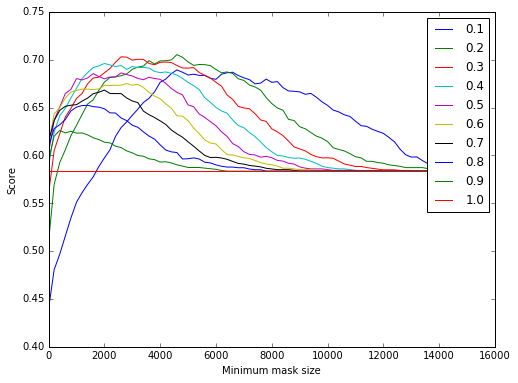

In [199]:
cutoffs, minimumsizes, filtscores = evaluate_cutoffs()

fig, ax = plt.subplots(figsize=(8,6))
ax.plot(minimumsizes, filtscores.T)
ax.legend(['{:.1f}'.format(c) for c in cutoffs])
ax.set_xlabel('Minimum mask size')
ax.set_ylabel('Score')

In [218]:
def convex_mask(predmasks):
    for i, mask in enumerate(predmasks):
        if np.any(mask):  #convex_hull fails if empty mask is given
            predmasks[i,:,:] = convex_hull_image(mask)
    return predmasks

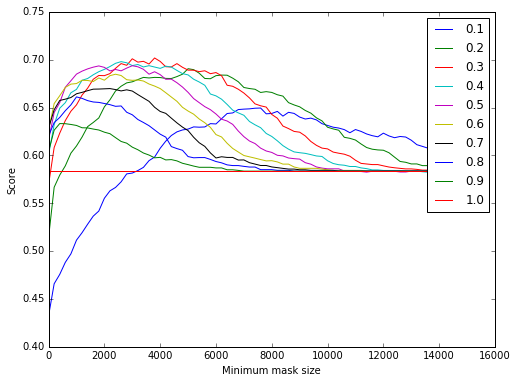

In [219]:
cutoffs, minimumsizes, filtscores = evaluate_cutoffs(maskfun=convex_mask)

fig, ax = plt.subplots(figsize=(8,6))
ax.plot(minimumsizes, filtscores.T)
ax.legend(['{:.1f}'.format(c) for c in cutoffs])
ax.set_xlabel('Minimum mask size')
ax.set_ylabel('Score')

In [74]:
def plot_pred_prob(idx, ax=None):
    if ax is None:
        fig, ax = plt.subplots(figsize=(8,6))    
    ax.imshow(data[idx,idxpred,:,:], alpha=1, cmap=plt.cm.plasma)
    ax.imshow(data[idx,idxmask,:,:], alpha=0.5, cmap=plt.cm.gray)
    ax.set_title(score[idx])
    return ax

def plot_pred_mask(idx, ax=None, cutoff=0.6, msk=None, scr=None):
    if ax is None:
        fig, ax = plt.subplots(figsize=(8,6))    
    ax.imshow(data[idx,idxpred,:,:], alpha=1, cmap=plt.cm.plasma)
    ax.imshow(data[idx,idxpred,:,:]>cutoff, alpha=0.5, cmap=plt.cm.gray_r)
    if msk is True:
        msk = uns.mask(255*data[idx,idxmask,:,:])
    if msk is not None:
        msk.plot_contour(ax=ax, c='r', lw=2.0)
    if scr is None:
        title = '{:.2f}'.format(scores[idx])
    else:
        title = '{:.2f} -> {:.2f}'.format(scores[idx], scr)
        
    ax.set_title(title)
    return ax



In [75]:
#indices = sorted(np.random.randint(0, 1101, (10)))
convex_score = [onedice(convex_mask(idx), ground_truth(idx)) for idx in range(len(scores))]

In [76]:
np.mean(convex_score)
        

0.61190356472816709

## Cycle through convex masks and filter out false positives

In [78]:
convex_masks = np.dstack([convex_mask(idx) for idx in range(len(scores))])


In [86]:
convex_pixels = np.sum(convex_masks, axis=(0,1))
convex_scores = [onedice(convex_masks[:,:,idx], ground_truth(idx)) for idx in range(len(scores))]
blank_mask = np.zeros_like(ground_truth(1))


NameError: name 'blank' is not defined

In [ ]:
subset = tr[tr['validate']].iloc[indices]
batch = uns.batch(subset)

for i,j in enumerate(indices[:20]):
    print(i,':',j, subset.iloc[i][['subject','img','hasmask']])
    ax = plot_pred_mask(j)
    batch[i].mask.plot_contour(ax=ax, lw=2.0, c='r')
    plt.show()
    

What do the masks in the bottleneck files look like?

In [ ]:
indices = [6,7]

In [ ]:
batch = uns.batch(tr[tr['validate']].iloc[indices])

imgpair = batch.pop(0)
print(imgpair.bottlefile)
i = indices.pop(0)
plot_pred_mask(i)
imgpair.plot()
record = np.fromfile('../bottleneck_files/' + imgpair.bottlefile, dtype=np.float32)

In [ ]:
fc6dim = 13, 18, 4096
pooldim = 26, 36, 512
maskdim = 416, 576, 2 

Nfc6 = np.prod(fc6dim)
Npool = np.prod(pooldim)
Nmask = np.prod(maskdim)
#print(record.shape, Nfc6 + Npool + Nmask)

fc6 = record[:Nfc6].reshape(fc6dim)
pool = record[Nfc6:Nfc6+Npool].reshape(pooldim)
mask = np.reshape(record[Nfc6+Npool:], maskdim)

fig,ax = plt.subplots(1,2,figsize=(12,4))
ax[0].imshow(mask[:,:,0], cmap=plt.cm.gray)
ax[1].imshow(mask[:,:,1], cmap=plt.cm.gray)

In [ ]:
j = np.argmax(np.sum(np.logical_and(mask[:,:,0]>0, data[:,idxmask,:,:]), axis=(2,1)))

plot_pred_mask(j)
print(j)